In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import time

In [2]:
edges_df = pd.read_csv("data_extracted_edges.csv")
nodes_df = pd.read_csv("data_extracted_nodes.csv")

In [3]:
def time_expanded(time, G, sink_nodes):
  from numpy import inf
  source_nodes = [g for g in G if g not in sink_nodes]
  te_G = nx.DiGraph()
  for t in range(time+1):
    for i in range(len(list(G))):
      te_G.add_node((str(list(G)[i]) + '(' + str(t) + ')'), pos = (t, len(list(G))-i))

    for k in range(len(list(te_G))-(len(source_nodes) + len(sink_nodes))):
      te_G.add_edge(str(list(te_G)[k]), str(list(te_G)[k + len(source_nodes) + len(sink_nodes)]), capacity = math.inf)
  te_G.add_node('x*', pos = (-1, len(source_nodes)))
  for i in range(len(sink_nodes)):
    te_G.add_node(str(sink_nodes[i]) + '*', pos = ((time+1)*(i+1)/(len(sink_nodes)+1), -len(sink_nodes)))
  for l in range(len(list(G))):
    te_G.add_edge('x*', str(list(te_G)[l]), capacity = nx.get_node_attributes(G, "evacuees")[list(G)[l]])
  te_G.add_node('zeta', pos = ((time+1)/2, -len(sink_nodes)-1))

  for t in range(time+1):
    for e in G.edges():
      weight = nx.get_edge_attributes(G, "weight")[e]
      if t+weight <= time:
        te_G.add_edge(str(list(e)[0]) + '(' + str(t) + ')', str(list(e)[1]) + '(' + str(t + (nx.get_edge_attributes(G, "weight"))[e]) + ')', capacity = nx.get_edge_attributes(G, "capacity")[e])
        te_G.add_edge(str(list(e)[1]) + '(' + str(t) + ')', str(list(e)[0]) + '(' + str(t + (nx.get_edge_attributes(G, "weight"))[e]) + ')', capacity = nx.get_edge_attributes(G, "capacity")[e])
    for i in range(len(sink_nodes)):
      te_G.add_edge(str(sink_nodes[i]) + '(' + str(t) + ')', str(sink_nodes[i]) + '*', capacity = math.inf)
  for i in range(len(sink_nodes)):
    te_G.add_edge(str(sink_nodes[i]) + '*', 'zeta', capacity = math.inf)
  return(te_G)

In [4]:
def flow_te(time, G, sink_nodes):
  flow_value = nx.maximum_flow_value(time_expanded(time, G, sink_nodes), "x*", "zeta")
  return(flow_value)

In [5]:
G = nx.Graph()

nodes = nodes_df['Node'].to_list()
G.add_nodes_from(nodes)
nodes_x = nodes_df['x'].to_list()
nodes_y = nodes_df['y'].to_list()
evacuees = nodes_df['Evacuees'].to_list()
nodes_attrs = {}
for i in range(len(nodes)):
  nodes_attrs[nodes[i]] = {'pos' : (nodes_x[i], nodes_y[i]), 'evacuees' : evacuees[i]}
nx.set_node_attributes(G, nodes_attrs)

edges = edges_df[['origin_id', 'destination']].values.tolist()
G.add_edges_from(edges)
weight = edges_df['total_cost'].to_list()
capacity = edges_df['width'].to_list()
edges_attrs = {}
for i in range(len(edges)):
  edges_attrs[tuple(edges[i])] = {'weight' : int(round(weight[i]/2,0)), 'capacity' : capacity[i]*2}
nx.set_edge_attributes(G, edges_attrs)

# Result of Problem 1

In [6]:
data_result = []

Number of facilities: 1
['J']
755
Time used in calculation: 57.8345627784729


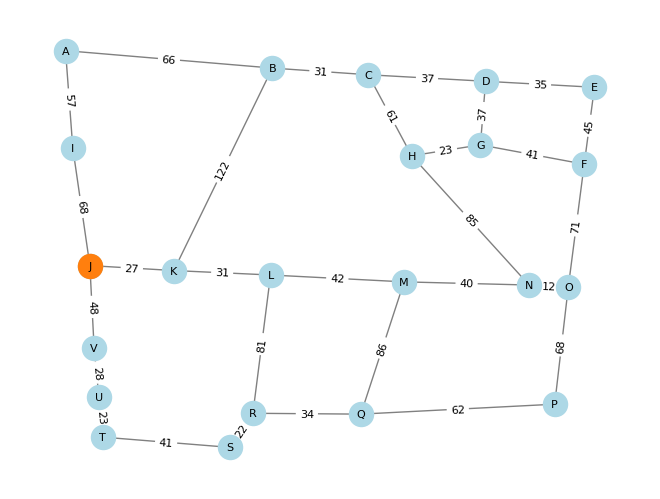

Number of facilities: 2
['J', 'B']
1103
Time used in calculation: 111.76058053970337


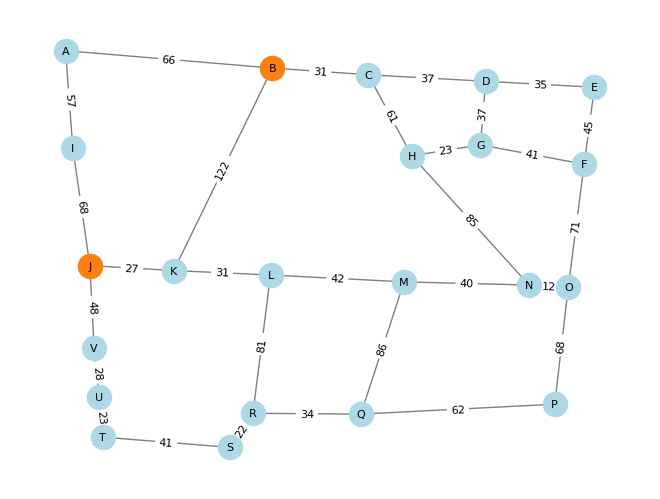

Number of facilities: 3
['J', 'B', 'Q']
1313
Time used in calculation: 180.09856390953064


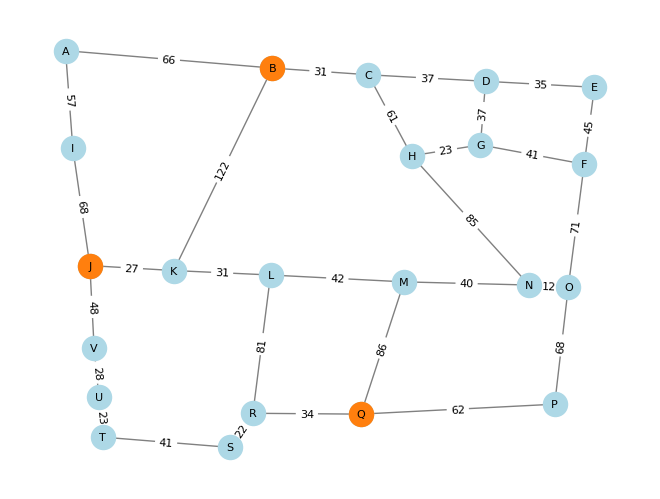

Number of facilities: 4
['J', 'B', 'Q', 'F']
1455
Time used in calculation: 234.04598760604858


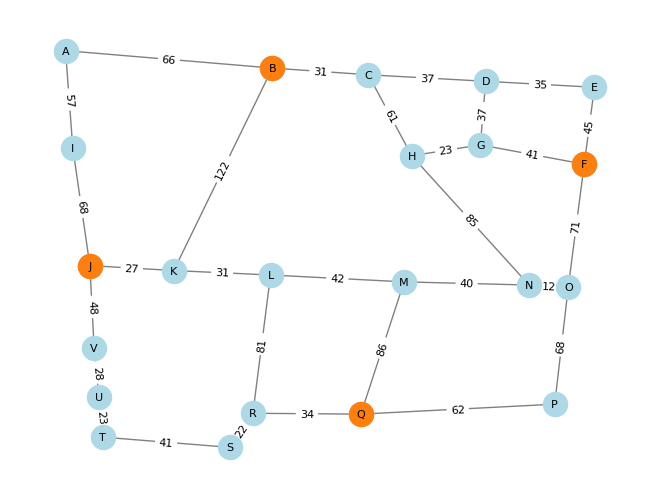

Number of facilities: 5
['J', 'B', 'Q', 'F', 'A']
1455
Time used in calculation: 280.94608521461487


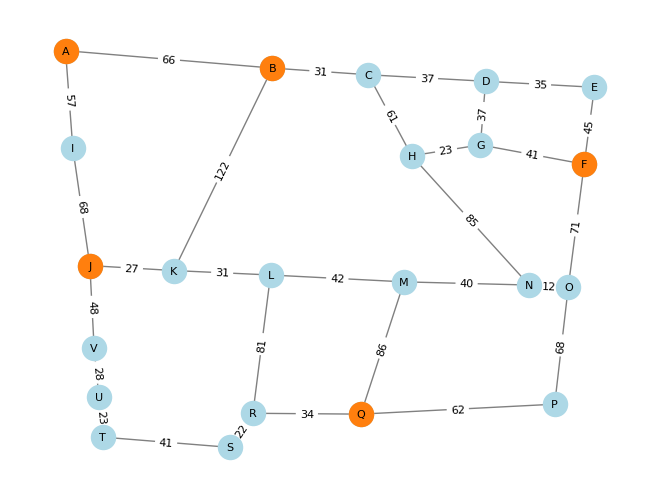

Number of facilities: 6
['J', 'B', 'Q', 'F', 'A', 'C']
1455
Time used in calculation: 321.5603392124176


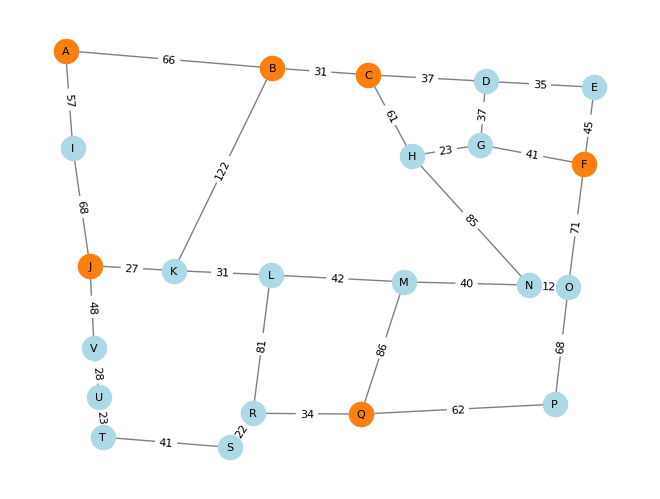

Number of facilities: 7
['J', 'B', 'Q', 'F', 'A', 'C', 'D']
1455
Time used in calculation: 362.4210755825043


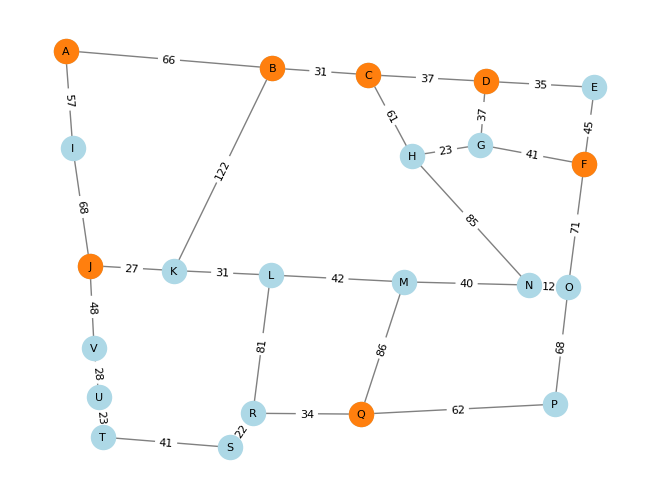

Number of facilities: 8
['J', 'B', 'Q', 'F', 'A', 'C', 'D', 'E']
1455
Time used in calculation: 399.4523150920868


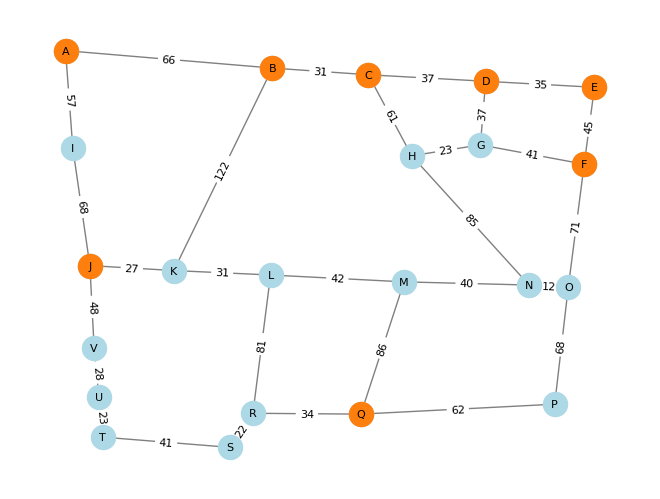

Number of facilities: 9
['J', 'B', 'Q', 'F', 'A', 'C', 'D', 'E', 'G']
1455
Time used in calculation: 401.35140681266785


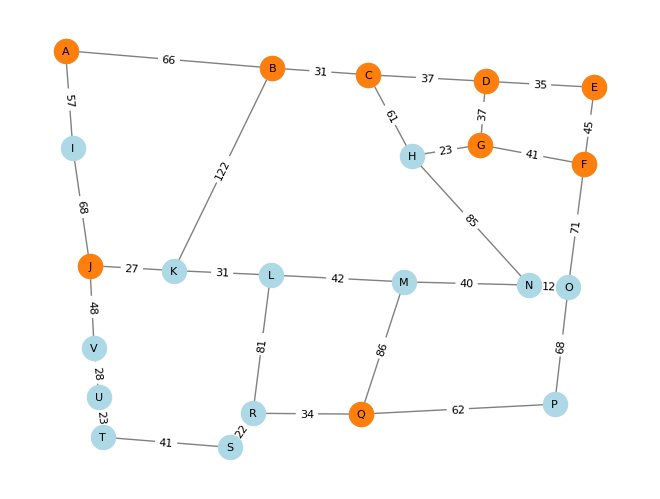

Number of facilities: 10
['J', 'B', 'Q', 'F', 'A', 'C', 'D', 'E', 'G', 'H']
1455
Time used in calculation: 393.8503875732422


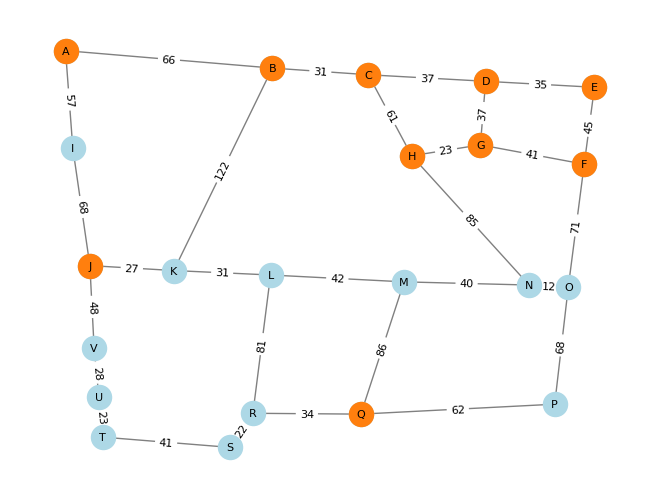

In [7]:
for n in range(10):
    m = n+1
    print('Number of facilities: '+ str(m))
    start = time.time()
    
    facility_list = []
    while len(facility_list) < m:
        max = 0
        for v in list(G):
            if v not in facility_list:
                if max < flow_te(100, G, facility_list + [v]):
                        max = flow_te(100, G, facility_list + [v])
                        v_max = v
        facility_list.append(v_max)

    stop = time.time()

    print(facility_list)
    print(max)
    print('Time used in calculation: '+ str(stop-start))

    data_result.append([m,max,stop-start,facility_list])

    pos = nx.get_node_attributes(G,'pos')
    sink_nodes = facility_list
    source_nodes = [g for g in G if g not in sink_nodes]
    edge_labels = nx.get_edge_attributes(G, "weight")

    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300, font_size=8)
    nx.draw_networkx_nodes(G, pos, nodelist = facility_list, node_size = 300, node_color="tab:orange")
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size = 8)
    plt.savefig('figure/network-flow-'+ str(m) +'.pdf')
    plt.show()

In [8]:
df = pd.DataFrame(data_result, columns=['facility number','flow(t)','flow time','x result'])
df

,facility number,flow(t),flow time,x result
0,1,755,57.834563,[J]
1,2,1103,111.760581,"[J, B]"
2,3,1313,180.098564,"[J, B, Q]"
3,4,1455,234.045988,"[J, B, Q, F]"
4,5,1455,280.946085,"[J, B, Q, F, A]"
5,6,1455,321.560339,"[J, B, Q, F, A, C]"
6,7,1455,362.421076,"[J, B, Q, F, A, C, D]"
7,8,1455,399.452315,"[J, B, Q, F, A, C, D, E]"
8,9,1455,401.351407,"[J, B, Q, F, A, C, D, E, G]"
9,10,1455,393.850388,"[J, B, Q, F, A, C, D, E, G, H]"


In [9]:
df.to_csv('csv/result-flow.csv', index=False)

# Result of Problem 2

Number of facilities: 1
['J']
755
Time used in calculation: 51.01148080825806
Number of facilities: 2
['J', 'B']
1103
Time used in calculation: 47.18034338951111
Number of facilities: 3
['J', 'B', 'Q']
1313
Time used in calculation: 56.881052017211914
Number of facilities: 4
['J', 'B', 'Q', 'F']
1455
Time used in calculation: 47.18804860115051
Time used in overall calculation: 212.61621618270874


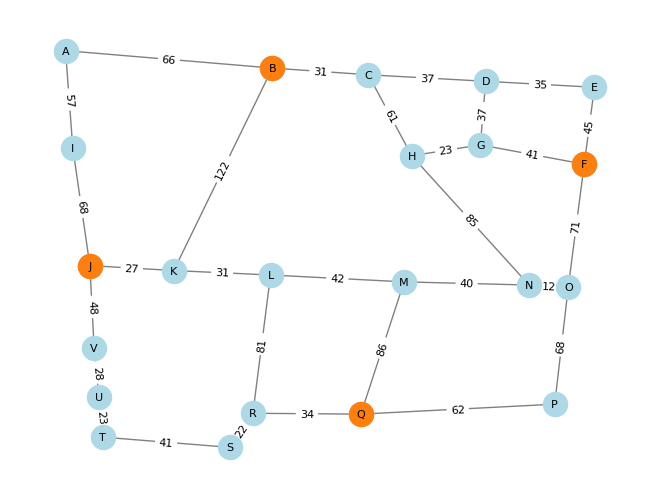

In [10]:
facility_list = []
n=0
start_all = time.time()
while flow_te(100, G, facility_list) < sum(nodes_df['Evacuees']):
  start = time.time()
  max = 0
  for v in list(G):
    if v not in facility_list:
      if max < flow_te(100, G, facility_list + [v]):
        max = flow_te(100, G, facility_list + [v])
        v_max = v
  facility_list.append(v_max)
  stop = time.time()
  n += 1
  print('Number of facilities: '+ str(n))
  print(facility_list)
  print(max)
  print('Time used in calculation: '+ str(stop-start)) 
stop_all = time.time()
print('Time used in overall calculation: '+ str(stop_all-start_all)) 

G_pos = nx.get_node_attributes(G, 'pos')
edge_labels = nx.get_edge_attributes(G, "weight")

nx.draw(G, G_pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300, font_size=8)
nx.draw_networkx_nodes(G, G_pos, nodelist = facility_list, node_size = 300, node_color="tab:orange")
nx.draw_networkx_edge_labels(G, G_pos, edge_labels, font_size = 8)
plt.savefig('figure/network-flow-p2.pdf')
plt.show()